In [1]:
import pandas as pd
pd.set_option('precision', 2)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors_ = plt.get_cmap('Set2')(np.linspace(0, 1, 8))
colors_year = plt.get_cmap('magma')(np.linspace(0.5, 1, 5)[::-1][1:])

from IPython.core.pylabtools import figsize
from IPython.display import display
figsize(8, 5)

%load_ext watermark
%load_ext autoreload
%autoreload 2
%matplotlib inline

%watermark -d -t -u -v -g -r -b -iv -a "Hongsup Shin" 

seaborn    0.10.0
pandas     1.0.3
matplotlib 3.1.3
numpy      1.18.1
Hongsup Shin 
last updated: 2020-08-06 15:20:23 

CPython 3.6.10
IPython 7.13.0
Git hash: af5d72a62837d88fa518c6f9cc5252e73590c3db
Git repo: https://github.com/hongsups/TJI_working_hshin.git
Git branch: master


In [2]:
# loading custom modules
import preprocess
import plot

# Data Summary of TJI's Officer-involved Shootings in Texas Report
This notebook shows the details of the Data Summary section of TJI's Officer-involved Shootings in Texas Report. This notebook is based on the civilian and officer data from TJI's website (downloaded in June 2020), which I preprocessed. The details of the preprocessing is described in `1.0-hs-preprocess_officer_involved_shooting_data.ipynb`.

# Note on Visualization and Styling
This notebook also includes visualization codes that were used to create the figures in the notebook. A graphic designer, Alyson Curtis from [Alyson Design](https://www.alysondesign.com/) and I have collaborated to create the final visualizations. I first created the figures from `matplotlib` and shared them with Alyson. Then Alyson provided me with a styling guide that includes information on the details of the graphics such as font type, size, and colors. The cell below includes that information from the guide. Note that most figures have their legends outside of the figure per Alyson's request.

In [3]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 10

plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.titleweight'] = 'bold'

plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['figure.titleweight'] = 'bold'

plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.edgecolor'] = 'white'

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

cols_race = ['#CE2827', '#3167AE', '#4C5151', '#B8BAB9']
cols_oag_tji = ['#929596', '#000000']
cols_gender = ['#183458', '#9b1f20']
cols_incident_causes = ['#000000', '#4c5151', '#6f7574', '#929596', '#b7bab9']
cols_year = cols_incident_causes[1:][::-1]
cols_deaths_injury = ['#9b1f20', '#183458']
cols_shot_deaths = ['#000000', '#9b1f20']
cols_bar = ['#6f7574']
cols_civilian_officer = ['#9b1f20', '#183458']

# Data

## The preprocessed datasets

In [4]:
df_cd = pd.read_pickle('../Data/Preprocessed/civilian_shooting_preprocessed.pkl'); print(df_cd.shape)
df_os = pd.read_pickle('../Data/Preprocessed/officer_shooting_preprocessed.pkl'); print(df_os.shape)

(697, 154)
(130, 50)


## Census data 
Loading the census data that shows general population information by race and county

In [5]:
df_census = pd.read_pickle('../Data/Interim/census_county_race_2010.pkl'); print(df_census.shape)

(254, 4)


In [6]:
df_census.head()

,WHITE,BLACK,HISPANIC,OTHER
County,,,,
ANDERSON,34383,12472,10550,1574
ANDREWS,6794,206,11371,307
ANGELINA,55069,13751,20476,2391
ARANSAS,15716,244,6896,868
ARCHER,8238,40,933,248


## Defining commonly used dataframes for convenience
We are using the following variables frequently, so we are going to defined them in the beginning of the notebook.

In [7]:
race_list = ['WHITE', 'BLACK', 'HISPANIC', 'OTHER']

# we will rearrange the incident_causes_list based on their size later
incident_causes_list = ['Traffic Stop', 
                        'Emergency/Request for Assistance', 
                        'Execution of a Warrant', 
                        'Hostage/Barricade/Other Emergency', 
                        'Other']

years = range(2016, 2020)

# For visualization, we are focusing on a subset of counties that have most incidents or highest general population (top 5 or top 10).
top5_locs = df_cd['incident_county'].value_counts()[:5].index.values
top10_locs = df_cd['incident_county'].value_counts()[:10].index.values
top10_by_census = df_census.sum(axis=1).sort_values()[::-1][:10].index.values
print(top5_locs)
print(top10_locs)
print(top10_by_census)

['HARRIS' 'BEXAR' 'DALLAS' 'TARRANT' 'TRAVIS']
['HARRIS' 'BEXAR' 'DALLAS' 'TARRANT' 'TRAVIS' 'EL PASO' 'GALVESTON'
 'HIDALGO' 'MONTGOMERY' 'CAMERON']
['HARRIS' 'DALLAS' 'TARRANT' 'BEXAR' 'TRAVIS' 'COLLIN' 'HIDALGO' 'EL PASO'
 'DENTON' 'FORT BEND']


In [8]:
df_cd_top5 = df_cd.loc[df_cd['incident_county'].isin(top5_locs), :]
df_os_top5 = df_os.loc[df_os['incident_county'].isin(top5_locs), :]

In [9]:
df_cd['incident_county_top10'] = df_cd['incident_county'].apply(lambda x: x if x in top10_by_census else 'OTHER')
df_cd['incident_top10'] = df_cd['incident_county'].apply(lambda x: x if x in top10_locs else 'OTHER')
df_cd['incident_top5'] = df_cd['incident_county'].apply(lambda x: x if x in top5_locs else 'OTHER')

Our analyses focus on the entire dataset but also the decedent only. We are defining the decedent dataset below.

In [10]:
df_cd_died = df_cd[df_cd['died']==1].copy()
df_os_died = df_os[df_os['officer_harm']=='DEATH'].copy()

# Civilian Data

## 1. Total number of reports

Number of counties which ever reported the incident:

In [11]:
df_cd['incident_county'].value_counts().shape

(121,)

Number of incidents by county and year as a stacked bar plot (showing only top 10 counties with the higest number of incidents)

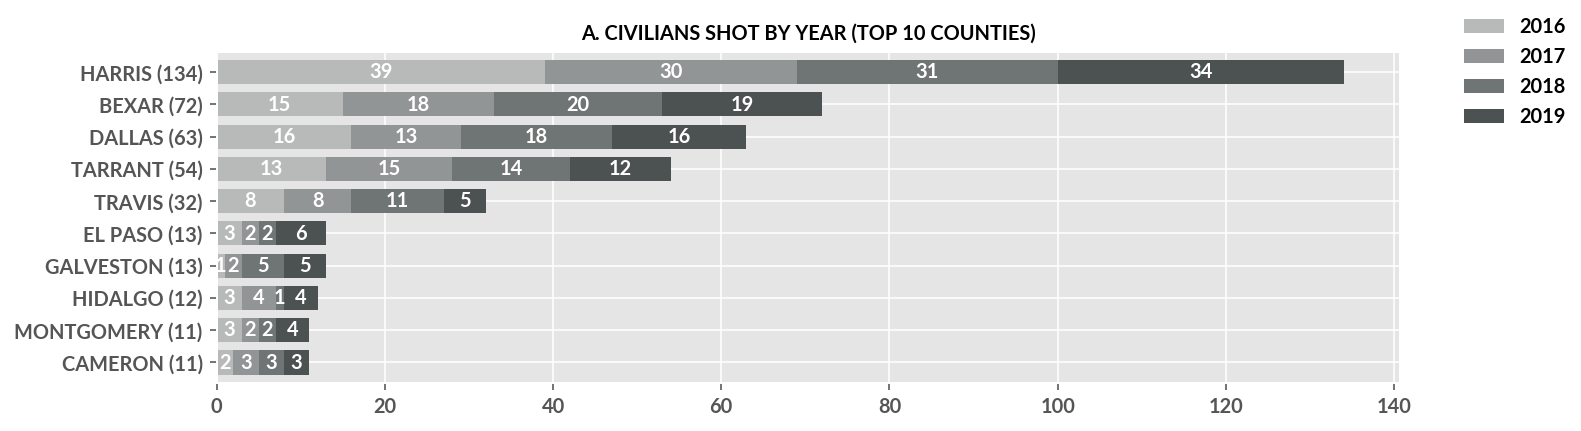

In [12]:
plot.plot_stackedbar_year_county(df_cd, 'A. CIVILIANS SHOT BY YEAR (TOP 10 COUNTIES)', total_count=True, colors=cols_year, 
                                 figsize=(10, 3), fname='../Figures/Figure_2A.eps')

Number of deaths by county and year as a stacked bar plot (showing only top 10 counties with the higest number of incidents)

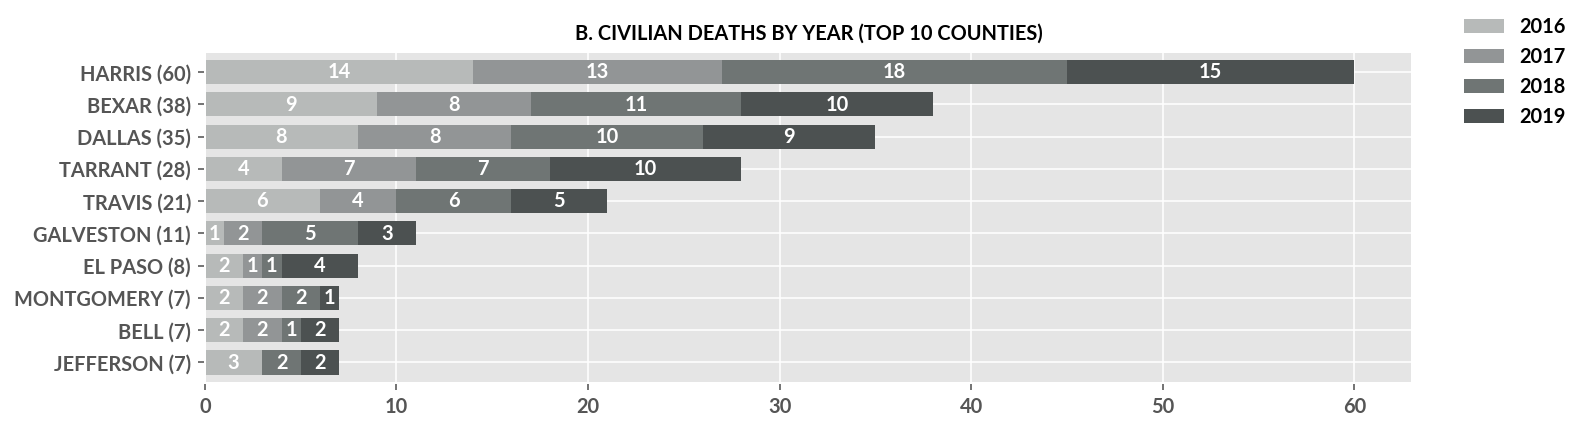

In [13]:
plot.plot_stackedbar_year_county(df_cd_died, 'B. CIVILIAN DEATHS BY YEAR (TOP 10 COUNTIES)', total_count=True, colors=cols_year, 
                                 figsize=(10, 3), fname='../Figures/Figure_2B.eps')

Gender demographics (all incidents)

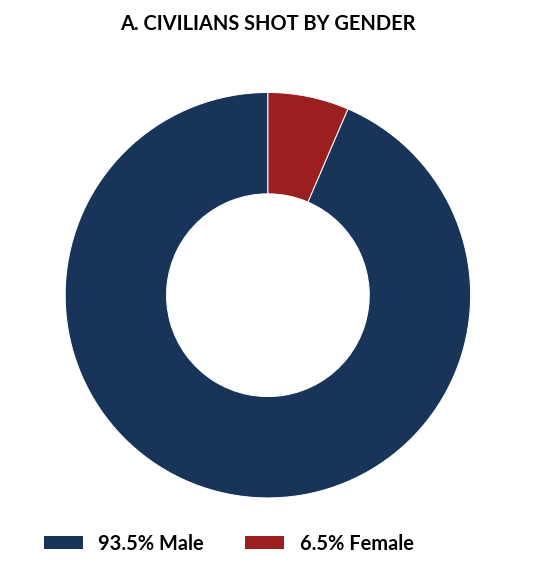

In [14]:
plot.plot_pie(df_cd, 'civilian_gender', colors=cols_gender, remove_labels=True, 
             title='A. Civilians shot by gender'.upper(),
             figsize=(4, 4), fname='../Figures/Figure_3A.eps')

Race demographics (all incidents)

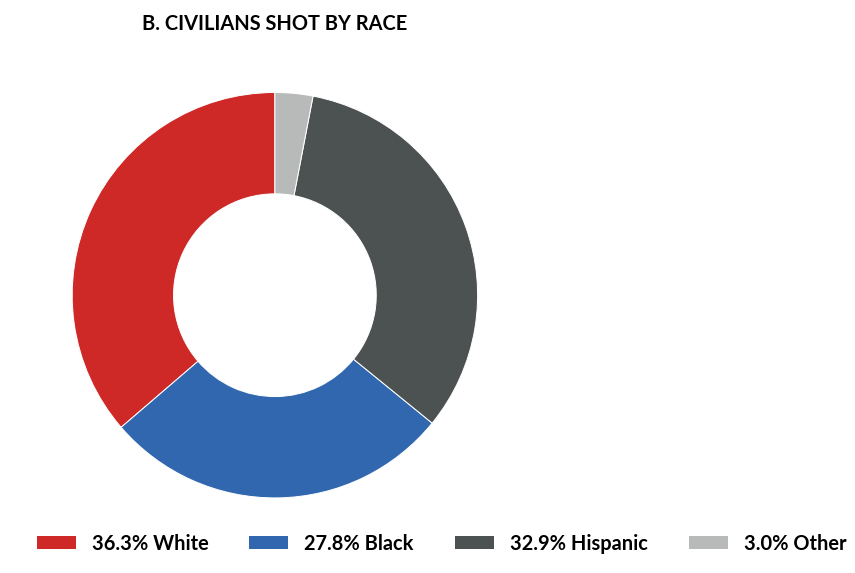

In [15]:
plot.plot_pie(df_cd, 'civilian_race', colors=cols_race, remove_labels=True, 
             title='B. Civilians shot by race'.upper(),
             figsize=(4, 4), fname='../Figures/Figure_3B.eps', 
             bbox_to_anchor=(1.5, 0.1))

## 2. Incidents by year, race and **county**

Male - all incidents

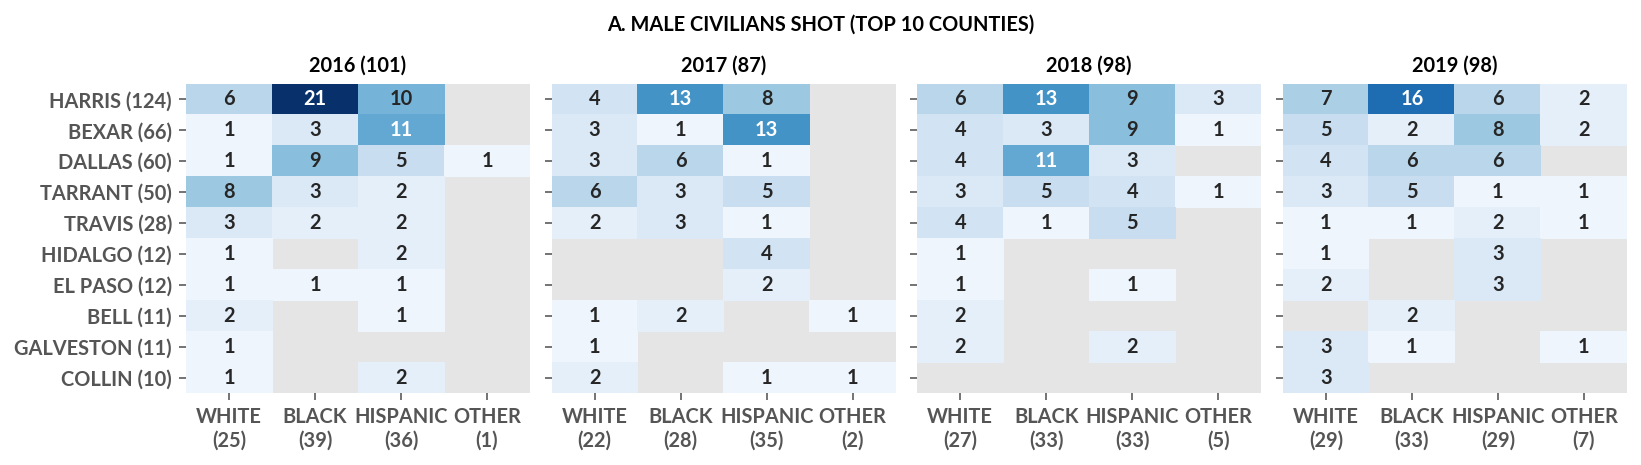

In [16]:
temp = df_cd[df_cd['civilian_gender']=='MALE']
plot.plot_heatmap_county_race_year(temp, figsize=(11.5, 3), cmap='Blues',
                                  title='A. Male Civilians Shot (Top 10 counties)'.upper(),
                                  fname='../Figures/Figure_4A.eps')

Male deaths

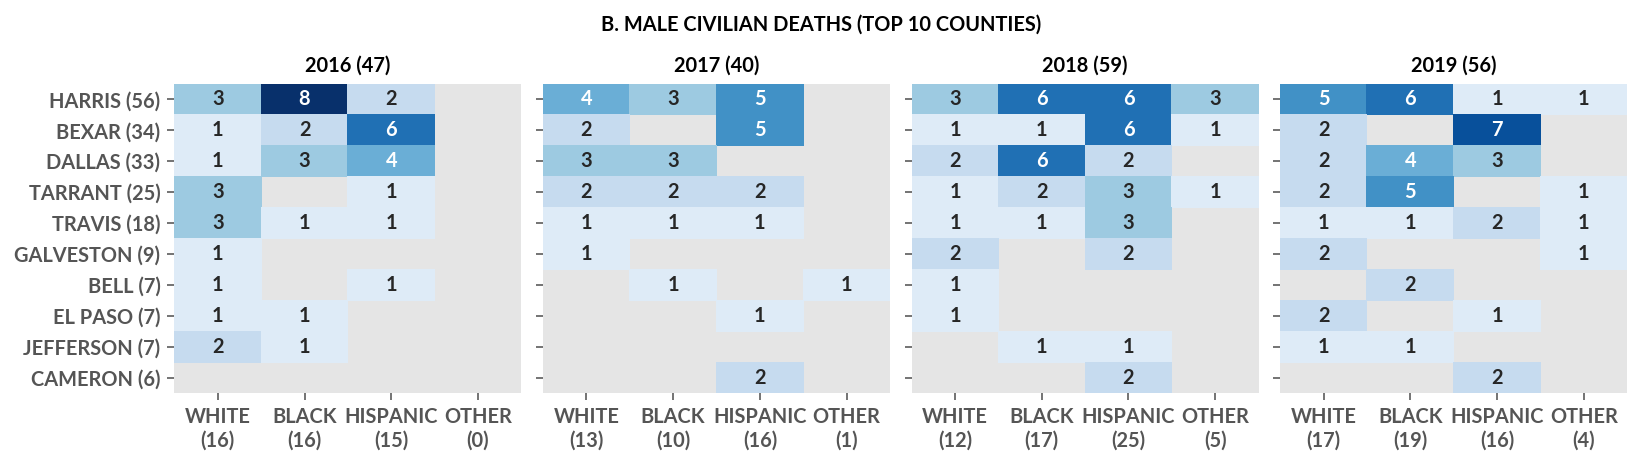

In [17]:
temp = df_cd_died[df_cd_died['civilian_gender']=='MALE']
plot.plot_heatmap_county_race_year(temp, figsize=(11.5, 3), cmap='Blues',
                                  title='B. Male Civilian Deaths (Top 10 counties)'.upper(),
                                  fname='../Figures/Figure_4B.eps')

Female - all incidents

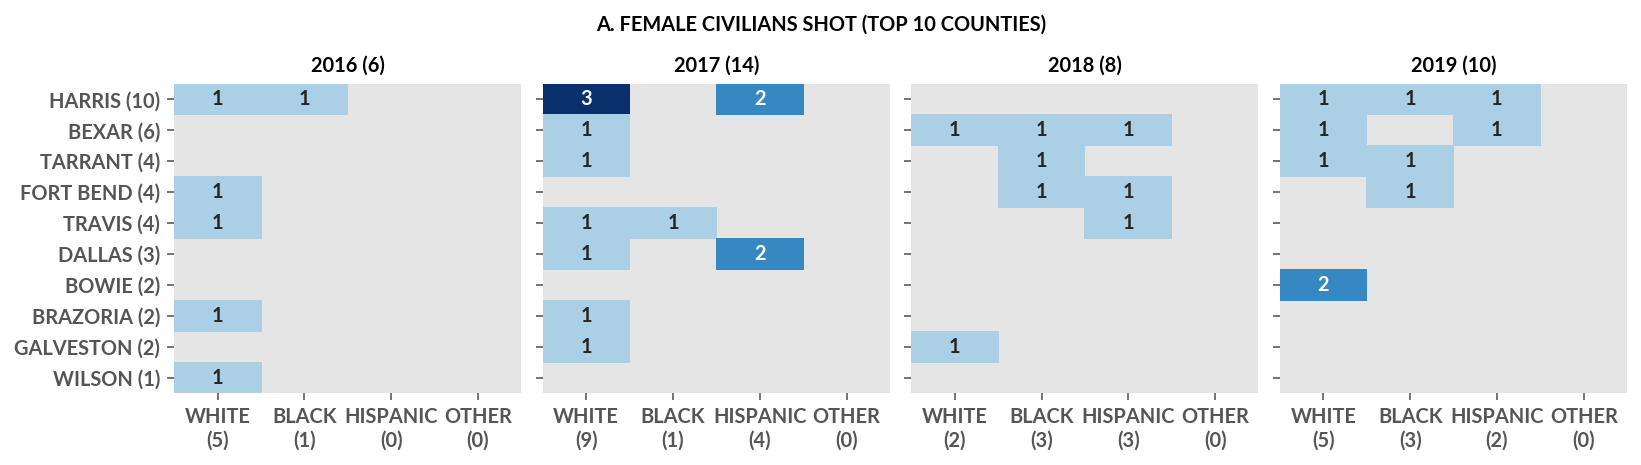

In [18]:
temp = df_cd[df_cd['civilian_gender']=='FEMALE']
plot.plot_heatmap_county_race_year(temp, figsize=(11.5, 3), cmap='Blues',
                                  title='A. Female Civilians Shot (Top 10 counties)'.upper(),
                                  fname='../Figures/Figure_5A.eps')

Female deaths

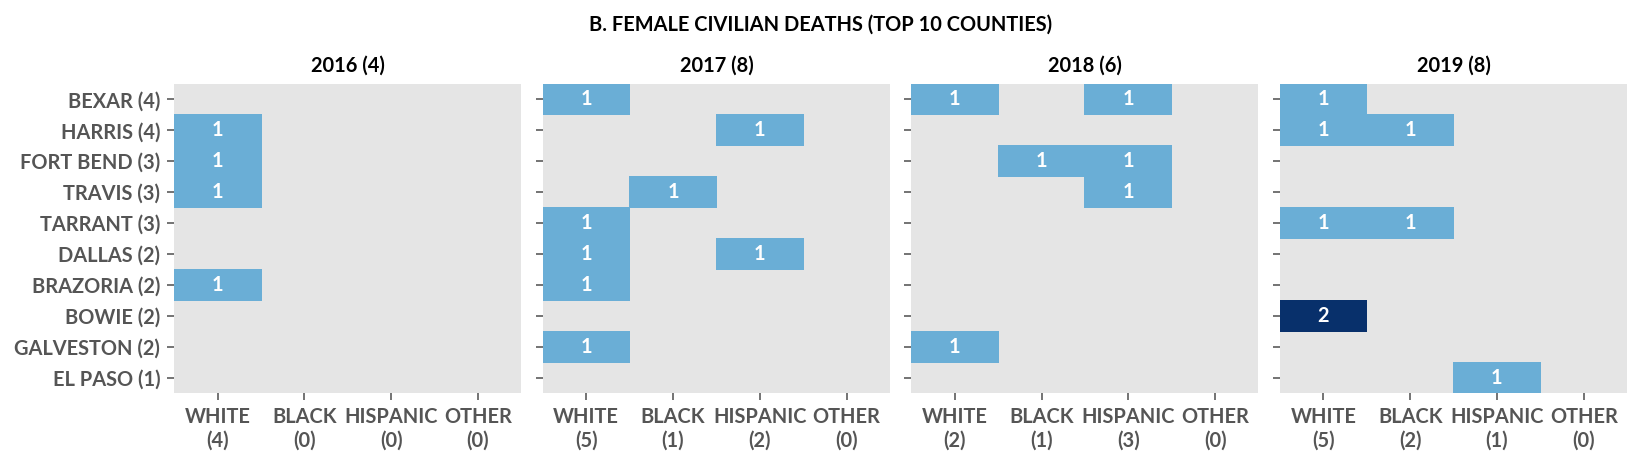

In [19]:
temp = df_cd_died[df_cd_died['civilian_gender']=='FEMALE']
plot.plot_heatmap_county_race_year(temp, figsize=(11.5, 3), cmap='Blues',
                                  title='B. Female Civilian deaths (Top 10 counties)'.upper(),
                                  fname='../Figures/Figure_5B.eps')

## 3. Incidents by year, race and **age groups**

In [20]:
age_names = ['1-4','5-14','15-24','25-34','35-44','45-54','55-64','65-74','75+']
len(age_names)

9

In [21]:
(df_cd['civilian_age_binned']==9).sum()

4

All incidents

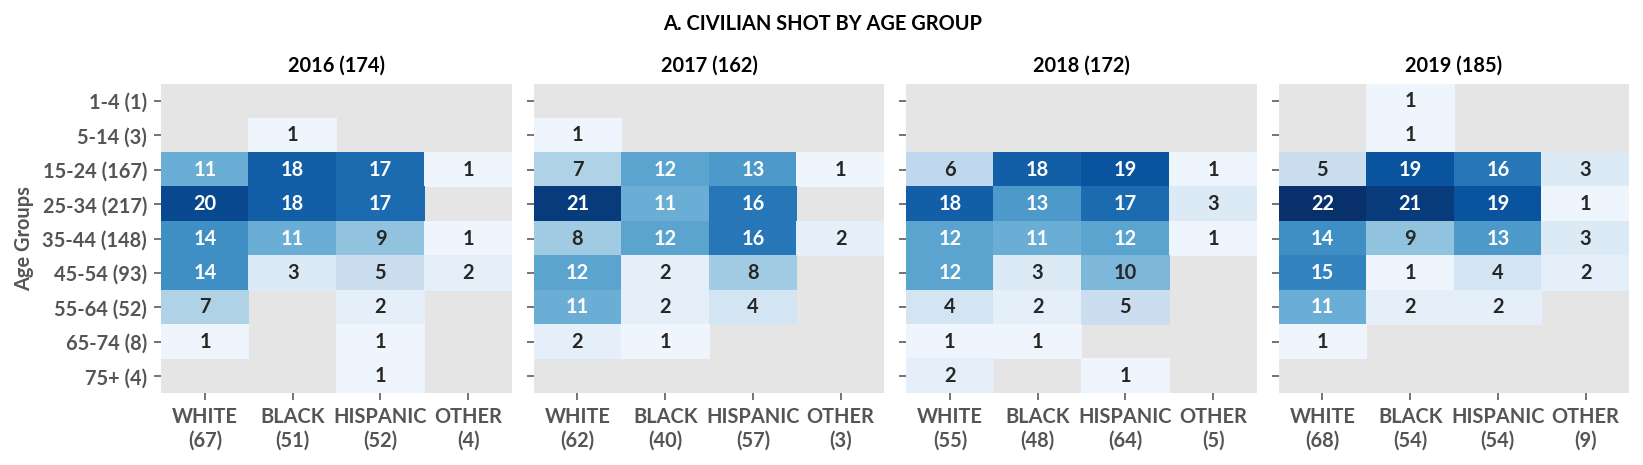

In [22]:
plot.plot_heatmap_age_race_year(df_cd, figsize=(11.5, 3), cmap='Blues',
                               title='A. Civilian shot by age group'.upper(),
                               fname='../Figures/Figure_6A.eps')

Deaths

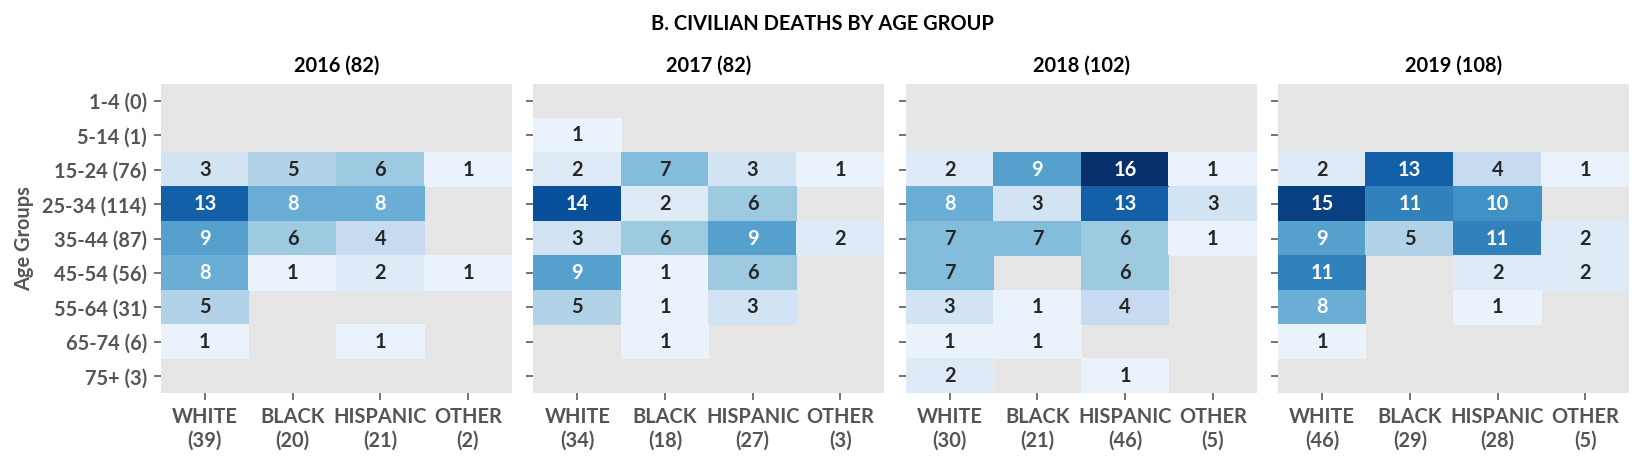

In [23]:
plot.plot_heatmap_age_race_year(df_cd_died, figsize=(11.5, 3), cmap='Blues',
                               title='B. Civilian deaths by age group'.upper(),
                               fname='../Figures/Figure_6B.eps')

A subset of the age groups (15-24 to 55-64) accounts for 97% of the incidents.

In [24]:
df_cd['civilian_age_binned'].value_counts().sort_index()[2:7].sum()/df_cd.shape[0]

0.9713055954088953

## 4. Incident causes

The majority of the incidents have single cause but there are cases with multiple causes.

In [25]:
df_cd[incident_causes_list].sum(axis=1).value_counts()/df_cd[incident_causes_list].sum(axis=1).sum()

1    8.42e-01
2    7.52e-02
3    2.64e-03
dtype: float64

In [26]:
df_cd[incident_causes_list].sum(axis=1).value_counts()

1    638
2     57
3      2
dtype: int64

The total number of incident causes described in the officer-involved shooting reports (all reports)

In [27]:
counts = df_cd[incident_causes_list].sum(axis=0)
counts.sort_values()

Hostage/Barricade/Other Emergency     37
Execution of a Warrant                71
Traffic Stop                          88
Other                                176
Emergency/Request for Assistance     386
dtype: int64

In [28]:
incident_causes_list_sorted = counts.sort_values(ascending=False).index
print(incident_causes_list_sorted)

Index(['Emergency/Request for Assistance', 'Other', 'Traffic Stop',
       'Execution of a Warrant', 'Hostage/Barricade/Other Emergency'],
      dtype='object')


Visualizing the proportions

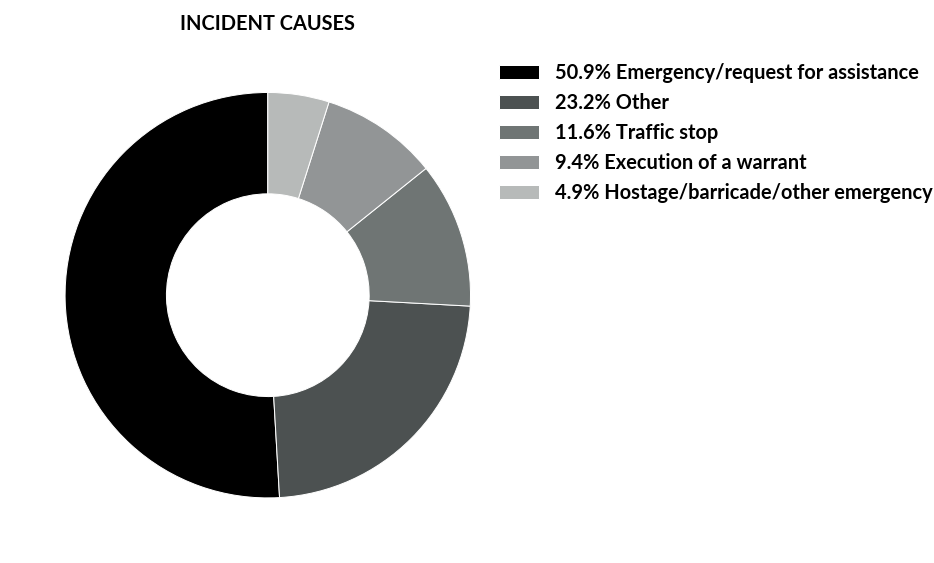

In [29]:
counts = df_cd[incident_causes_list_sorted].sum(axis=0)
    
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.pie(counts, startangle=90, labels=None, colors=cols_incident_causes,
       wedgeprops=dict(width=0.5, edgecolor='w'))

ax.set_title('Incident Causes'.upper(), fontsize=10)

pct_counts = counts/counts.sum()*100
legend_txt = ['{:.1f}% {}'.format(n, s.capitalize()) for s, n in zip(counts.index, pct_counts)]

fig.legend(legend_txt, ncol=1, bbox_to_anchor=(1.15, 0, 0.5, 0.9), fontsize=10)
fig.tight_layout()
    
fig.savefig('../Figures/Figure_7.eps', bbox_inches='tight')        

Incident causes by county (all reports)

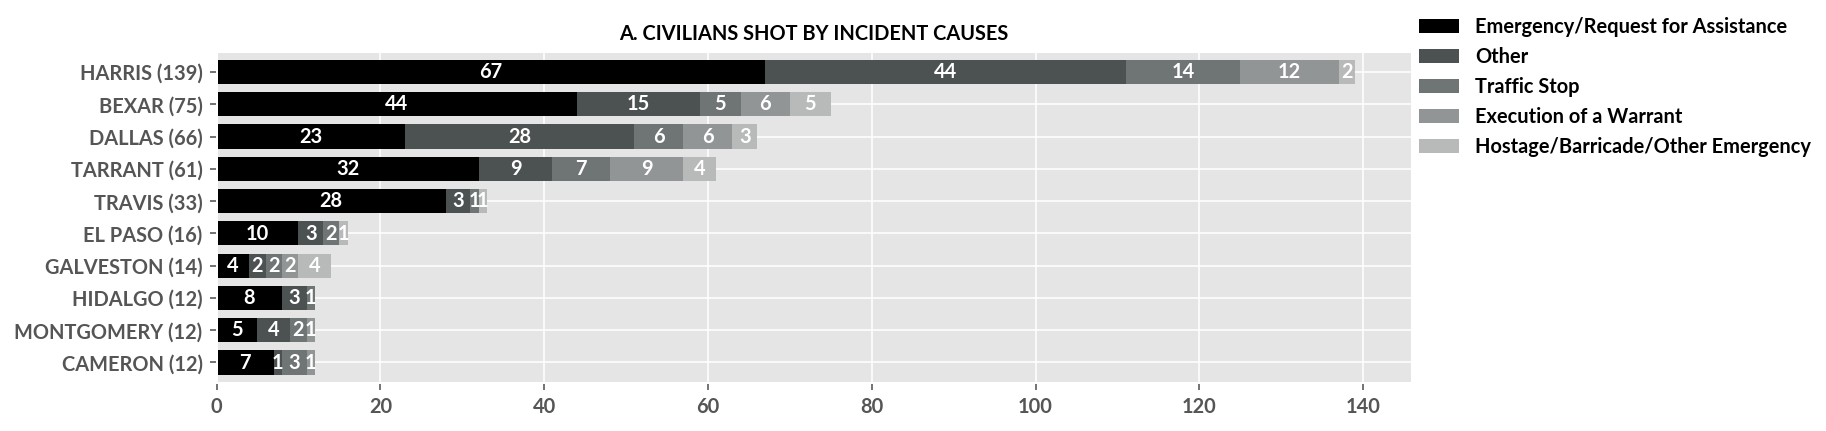

In [30]:
n_county = 10
inds_in_order = df_cd['incident_county'].value_counts()[:n_county][::-1].index

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
temp = df_cd.groupby('incident_county')[incident_causes_list_sorted].sum().loc[inds_in_order, :]
temp.plot.barh(stacked=True, color=cols_incident_causes, ax=ax, width=0.75, legend=False)
ax.set_yticklabels([s + ' ({})'.format(int(n)) for s, n in zip(inds_in_order, temp.sum(axis=1))], rotation=0)
plot.annotate(ax, 'h', fontsize=10)
ax.set_title('A. Civilians shot by incident causes'.upper(), fontsize=10)

fig.legend(incident_causes_list_sorted, ncol=1, bbox_to_anchor=(1.27, 1), fontsize=10)
fig.tight_layout()    
fig.savefig('../Figures/Figure_8A.eps', bbox_inches='tight')        

Incident causes by county (deaths only)

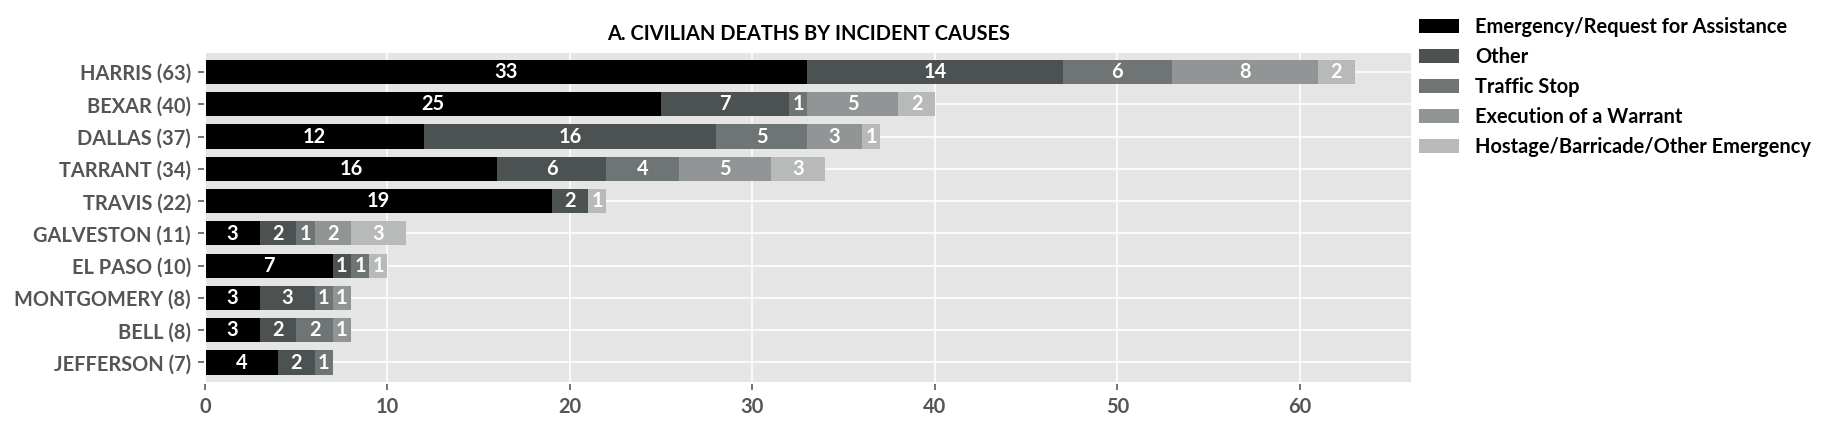

In [31]:
n_county = 10
inds_in_order = df_cd_died['incident_county'].value_counts()[:n_county][::-1].index

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
temp = df_cd_died.groupby('incident_county')[incident_causes_list_sorted].sum().loc[inds_in_order, :]
temp.plot.barh(stacked=True, color=cols_incident_causes, ax=ax, width=0.75, legend=False)
ax.set_yticklabels([s + ' ({})'.format(int(n)) for s, n in zip(inds_in_order, temp.sum(axis=1))], rotation=0)
plot.annotate(ax, 'h', fontsize=10)
ax.set_title('A. Civilian deaths by incident causes'.upper(), fontsize=10)

fig.legend(incident_causes_list_sorted, ncol=1, bbox_to_anchor=(1.27, 1), fontsize=10)
fig.tight_layout()    
fig.savefig('../Figures/Figure_8B.eps', bbox_inches='tight')        

## 5. Incidents by incident cause, race and age groups

All incidents

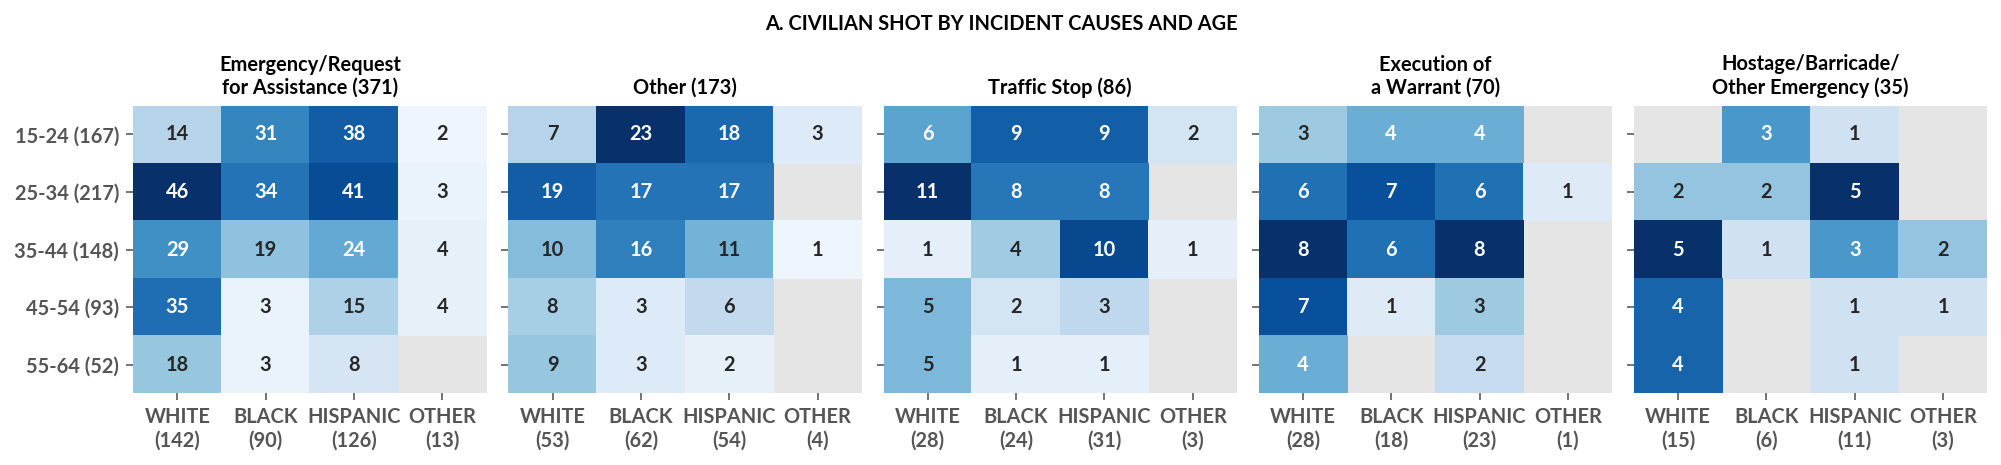

In [32]:
plot.plot_heatmap_age_race_cause(df_cd, figsize=(14, 3), cmap='Blues',
                               title='A. Civilian shot by incident causes and age'.upper(),
                               fname='../Figures/Figure_9A.eps')

Deaths

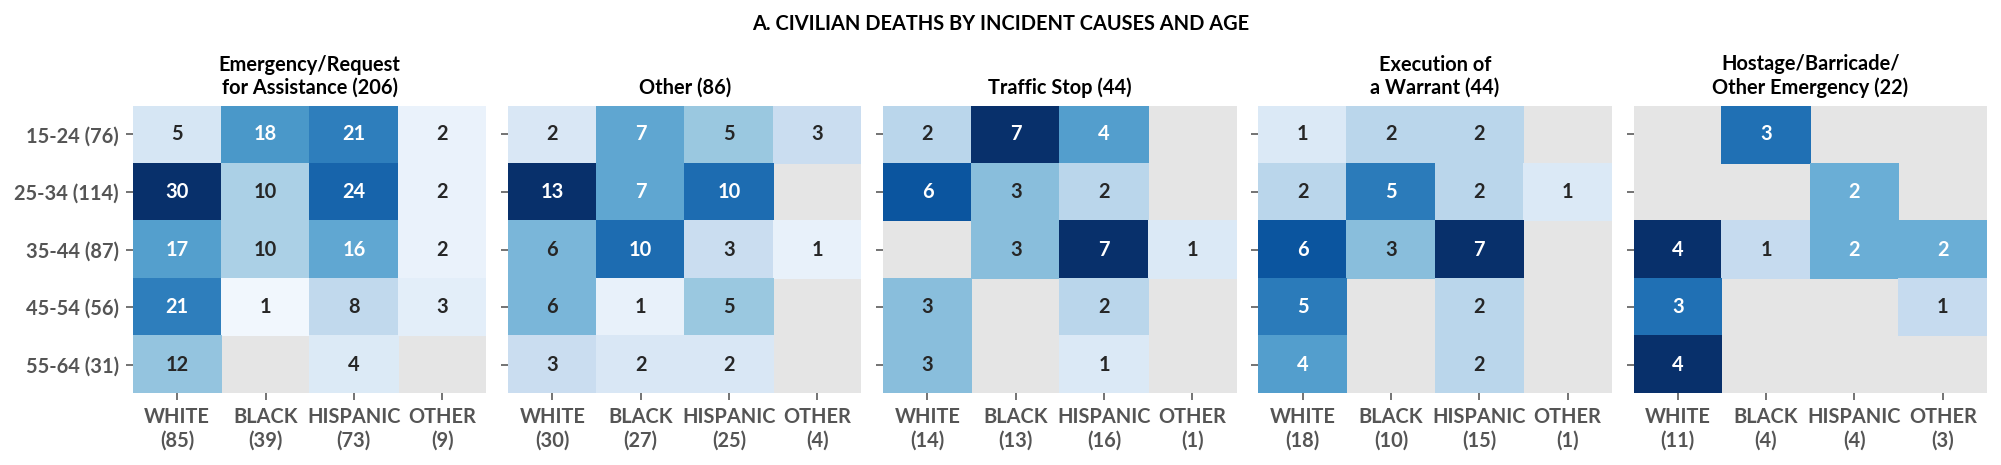

In [33]:
plot.plot_heatmap_age_race_cause(df_cd_died, figsize=(14, 3), cmap='Blues',
                               title='A. Civilian deaths by incident causes and age'.upper(),
                               fname='../Figures/Figure_9B.eps')

# Officer data

## 1. Incidents by year

In [34]:
df_os['year'].value_counts()

2019    41
2016    37
2018    26
2017    26
Name: year, dtype: int64

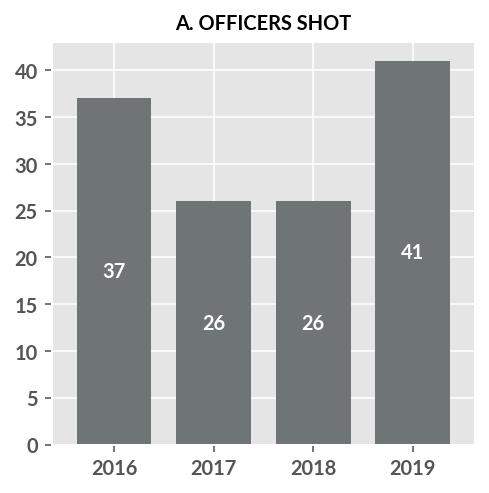

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
df_os['year'].value_counts().sort_index().plot.bar(rot=0, color=cols_bar, ax=ax, width=0.75)
plot.annotate(ax, 'v', fontsize=10)
ax.set_title('A. Officers Shot'.upper(), fontsize=10)
fig.tight_layout()
fig.savefig('../Figures/Figure_10A.eps')

## 2. Incidents by year and county

All incidents

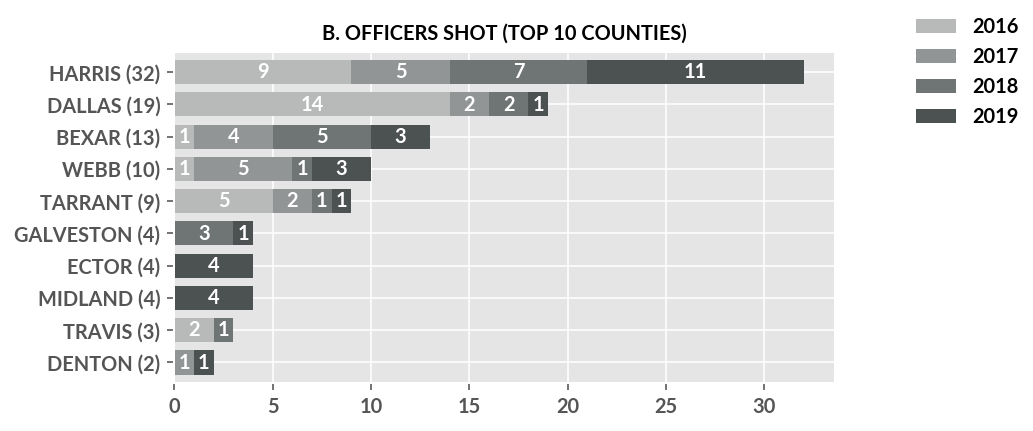

In [36]:
plot.plot_stackedbar_year_county(df_os, 
                                'B. Officers shot (top 10 counties)'.upper(), 
                                total_count=True, 
                                colors=cols_year, 
                                figsize=(6, 3), 
                                bbox_to_anchor=(1.2, 1),
                                fname='../Figures/Figure_10B.eps')

Deaths

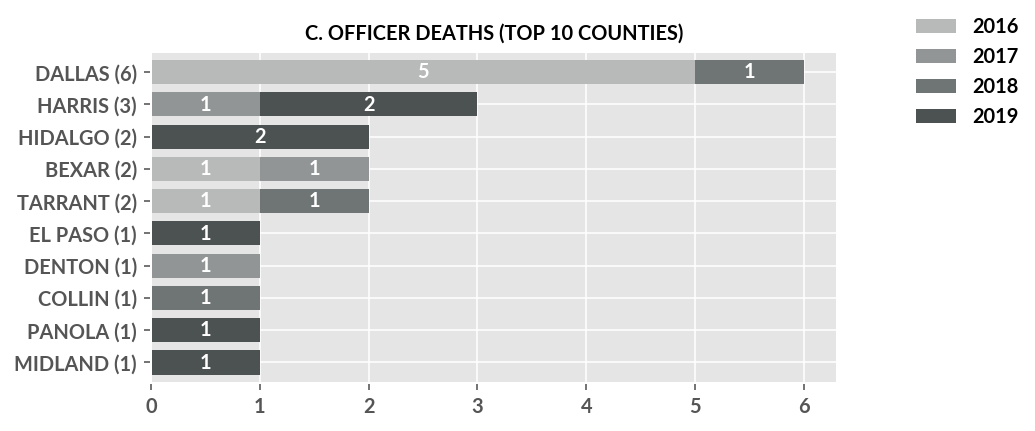

In [37]:
plot.plot_stackedbar_year_county(df_os_died, 
                                'C. Officer deaths (top 10 counties)'.upper(), 
                                total_count=True, 
                                colors=cols_year, 
                                figsize=(6, 3), 
                                bbox_to_anchor=(1.2, 1),
                                fname='../Figures/Figure_10C.eps')

## 3. Demographics

Gender demographics

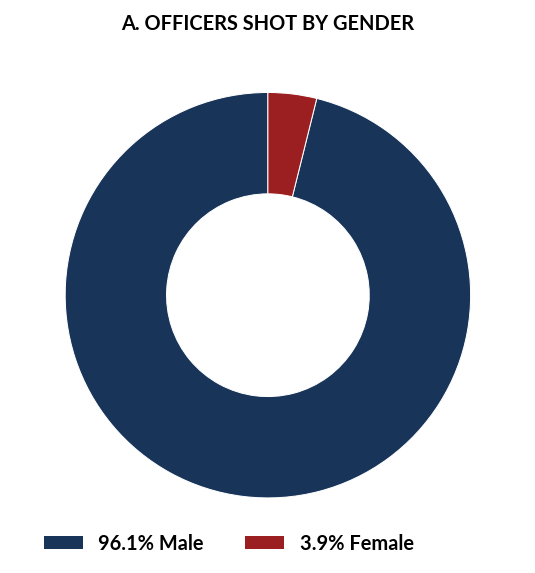

In [38]:
plot.plot_pie(df_os, 'officer_gender', colors=cols_gender, remove_labels=True, 
             title='A. officers shot by gender'.upper(),
             figsize=(4, 4), fname='../Figures/Figure_11A.eps')

Race demographics

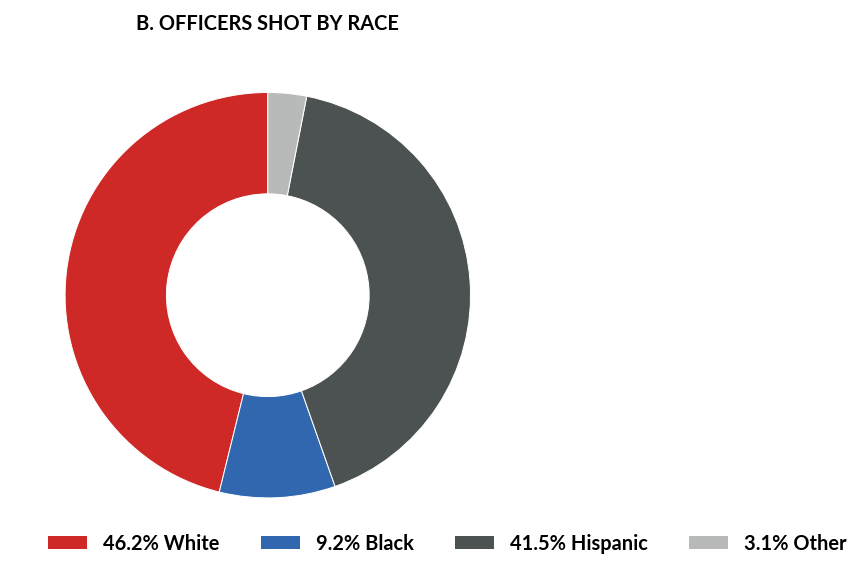

In [39]:
plot.plot_pie(df_os, 'officer_race', colors=cols_race, remove_labels=True, 
             title='B. officers shot by race'.upper(),
             figsize=(4, 4), fname='../Figures/Figure_11B.eps', bbox_to_anchor=(1.5, 0.1))

## 4. Incidents by year, race and county

All incidents

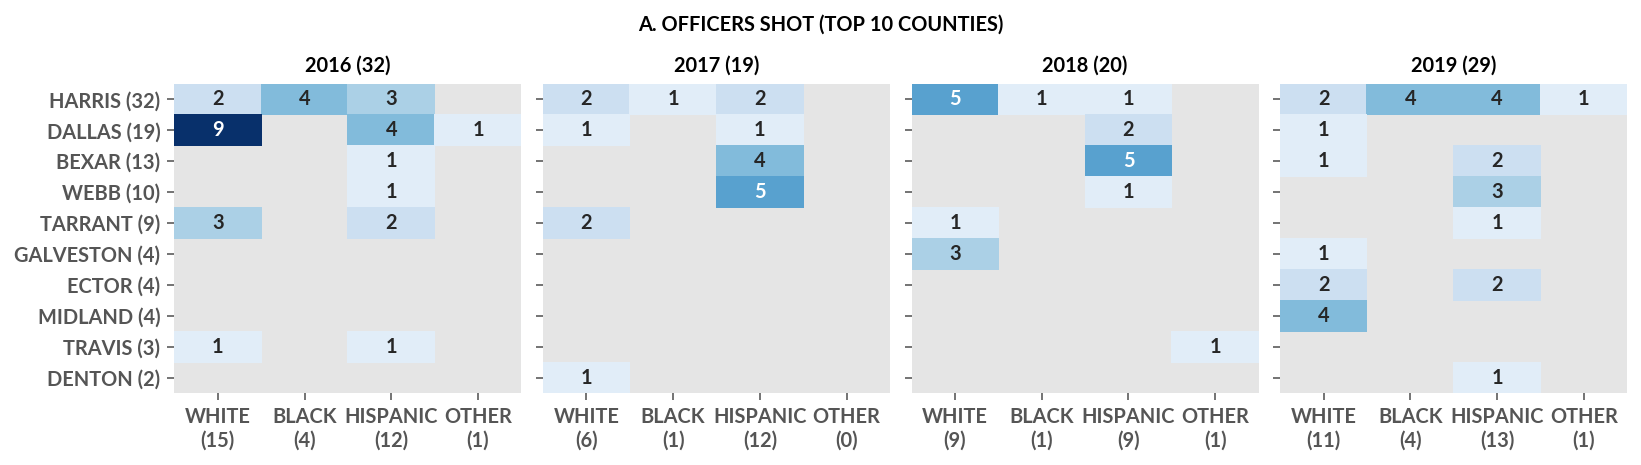

In [40]:
plot.plot_heatmap_county_race_year(df_os, df_type='officer', figsize=(11.5, 3), cmap='Blues',
                                  title='A. Officers Shot (Top 10 counties)'.upper(),
                                  fname='../Figures/Figure_12A.eps')

Deaths

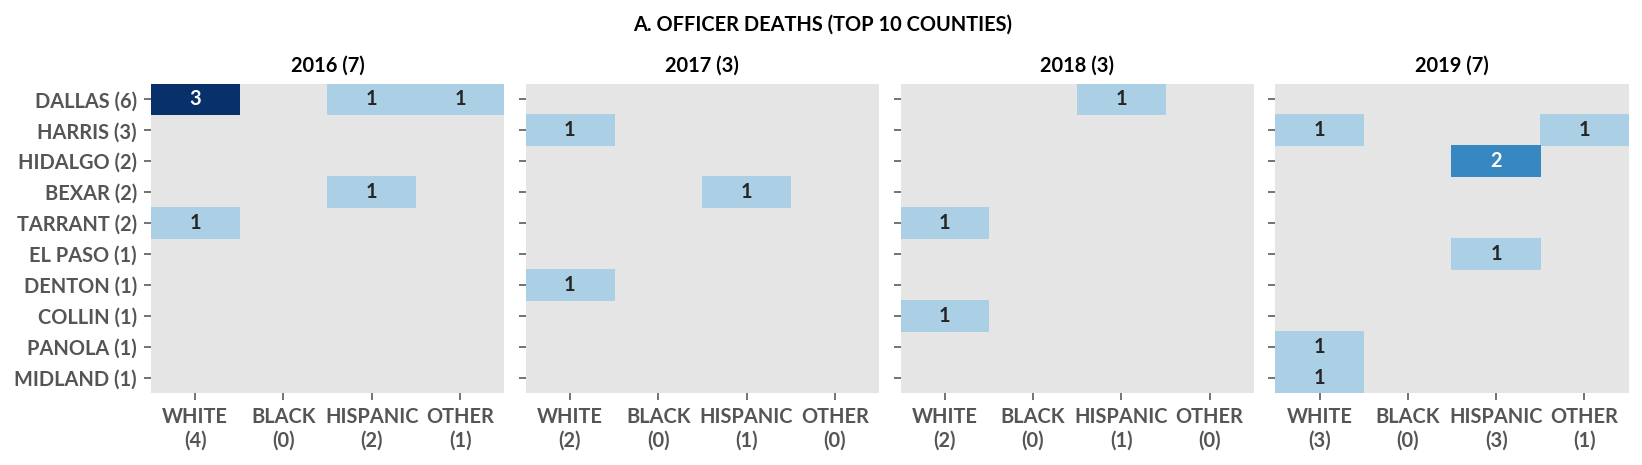

In [41]:
plot.plot_heatmap_county_race_year(df_os_died, df_type='officer', figsize=(11.5, 3), cmap='Blues',
                                  title='A. Officer deaths (Top 10 counties)'.upper(),
                                  fname='../Figures/Figure_12B.eps')

## 5. Age distribution

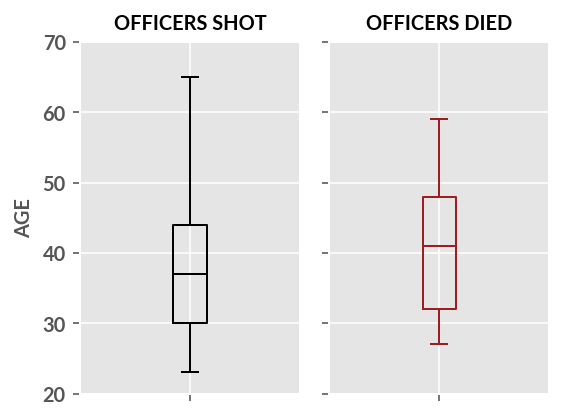

In [42]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(4, 3))
df_os['officer_age'].plot.box(color=cols_shot_deaths[0], ax=axes[0])
df_os_died['officer_age'].plot.box(color=cols_shot_deaths[1], ax=axes[1])
axes[0].set(ylim=(20,70), Title='Officers Shot'.upper(), xticklabels='', ylabel='AGE', xlabel=None)
axes[1].set(Title='Officers died'.upper(), xticklabels='', xlabel=None)

fig.tight_layout()
fig.savefig('../Figures/Figure_13.eps', bbox_inches='tight')

Median age

In [43]:
df_os['officer_age'].median(), df_os_died['officer_age'].median()

(37.0, 41.0)

# Agency data

Counting the number of incidents filed by each agency. We can do this separately for civilian and officers or together. In our report, we presented the combined data.

## 1. Civilian dataset
In the TJI dataset, the agency names are addressed in multiple columns.

In [44]:
print(df_cd.columns[df_cd.columns.str.contains('agency_name_')].sort_values())

Index(['agency_name_1', 'agency_name_10', 'agency_name_11', 'agency_name_2',
       'agency_name_3', 'agency_name_4', 'agency_name_5', 'agency_name_6',
       'agency_name_7', 'agency_name_8', 'agency_name_9',
       'agency_name_person_filling_out_1', 'agency_name_person_filling_out_10',
       'agency_name_person_filling_out_11', 'agency_name_person_filling_out_2',
       'agency_name_person_filling_out_3', 'agency_name_person_filling_out_4',
       'agency_name_person_filling_out_5', 'agency_name_person_filling_out_6',
       'agency_name_person_filling_out_7', 'agency_name_person_filling_out_8',
       'agency_name_person_filling_out_9'],
      dtype='object')


In [45]:
agency_names_cd = ['agency_name_' + str(n) for n in range(1, 12)]
print(agency_names_cd)

['agency_name_1', 'agency_name_2', 'agency_name_3', 'agency_name_4', 'agency_name_5', 'agency_name_6', 'agency_name_7', 'agency_name_8', 'agency_name_9', 'agency_name_10', 'agency_name_11']


In [46]:
df_cd[agency_names_cd].head()

,agency_name_1,agency_name_2,agency_name_3,agency_name_4,agency_name_5,agency_name_6,agency_name_7,agency_name_8,agency_name_9,agency_name_10,agency_name_11
66,SWEETWATER POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,FORNEY POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,ABILENE POLICE DEPT,ABILENE POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,SAN ANTONIO POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,FORNEY POLICE DEPT,FORNEY POLICE DEPT,MESQUITE POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are three categories of agencies: police department, sherrif's office and others. Here we compute the count by year and agency type.

In [47]:
df_agency_count, df_agency_count_plot = preprocess.count_agencies_by_year_type(df_cd, agency_names_cd, 5)

In [48]:
df_agency_count

,n_police,police_top,n_sheriff,sheriff_top,n_other,other_top
2016,63,HOUSTON POLICE DEPT 43 SAN ANTONIO POLI...,25,HARRIS CO SHERIFFS OFFICE 12 AUSTIN CO ...,6,TEXAS DEPT OF PUBLIC SAFETY 27 HARRIS CO CO...
2017,50,HOUSTON POLICE DEPT 47 SAN ANTONIO POLI...,25,HARRIS CO SHERIFFS OFFICE 16 BEXAR CO S...,9,TEXAS DEPT OF PUBLIC SAFETY 18 HARRIS CO CO...
2018,62,AUSTIN POLICE DEPT 24 HOUSTON POLICE D...,21,HARRIS CO SHERIFFS OFFICE 15 BEXAR CO S...,6,TEXAS DEPT OF PUBLIC SAFETY 26 HARRIS CO CO...
2019,57,HOUSTON POLICE DEPT 41 SAN ANTONIO POLI...,22,HARRIS CO SHERIFFS OFFICE 10 HARRISON C...,3,TEXAS DEPT OF PUBLIC SAFETY 26 OFFICE OF TH...


In [49]:
df_agency_count_plot

{'police':       HOUSTON  SAN ANTONIO  FORT WORTH  DALLAS  AUSTIN
 2016       43           15          13      13      11
 2017       47           13          13       8      10
 2018       17           15          13       9      24
 2019       41           27          12      16      11,
 'sheriff':       HARRIS CO  AUSTIN CO  MONTGOMERY CO  BEXAR CO  HARRISON CO
 2016       12.0        3.0            2.0       0.0          0.0
 2017       16.0        3.0            2.0       9.0          0.0
 2018       15.0        0.0            1.0       5.0          1.0
 2019       10.0        0.0            3.0       4.0          5.0,
 'other':       TEXAS DEPT OF PUBLIC SAFETY  HARRIS CO CONST PCT 3  \
 2016                         27.0                    1.0   
 2017                         18.0                    1.0   
 2018                         26.0                    2.0   
 2019                         26.0                    0.0   
 
       HARRIS CO CONST PCT 4  CAMERON CO CONST PCT 

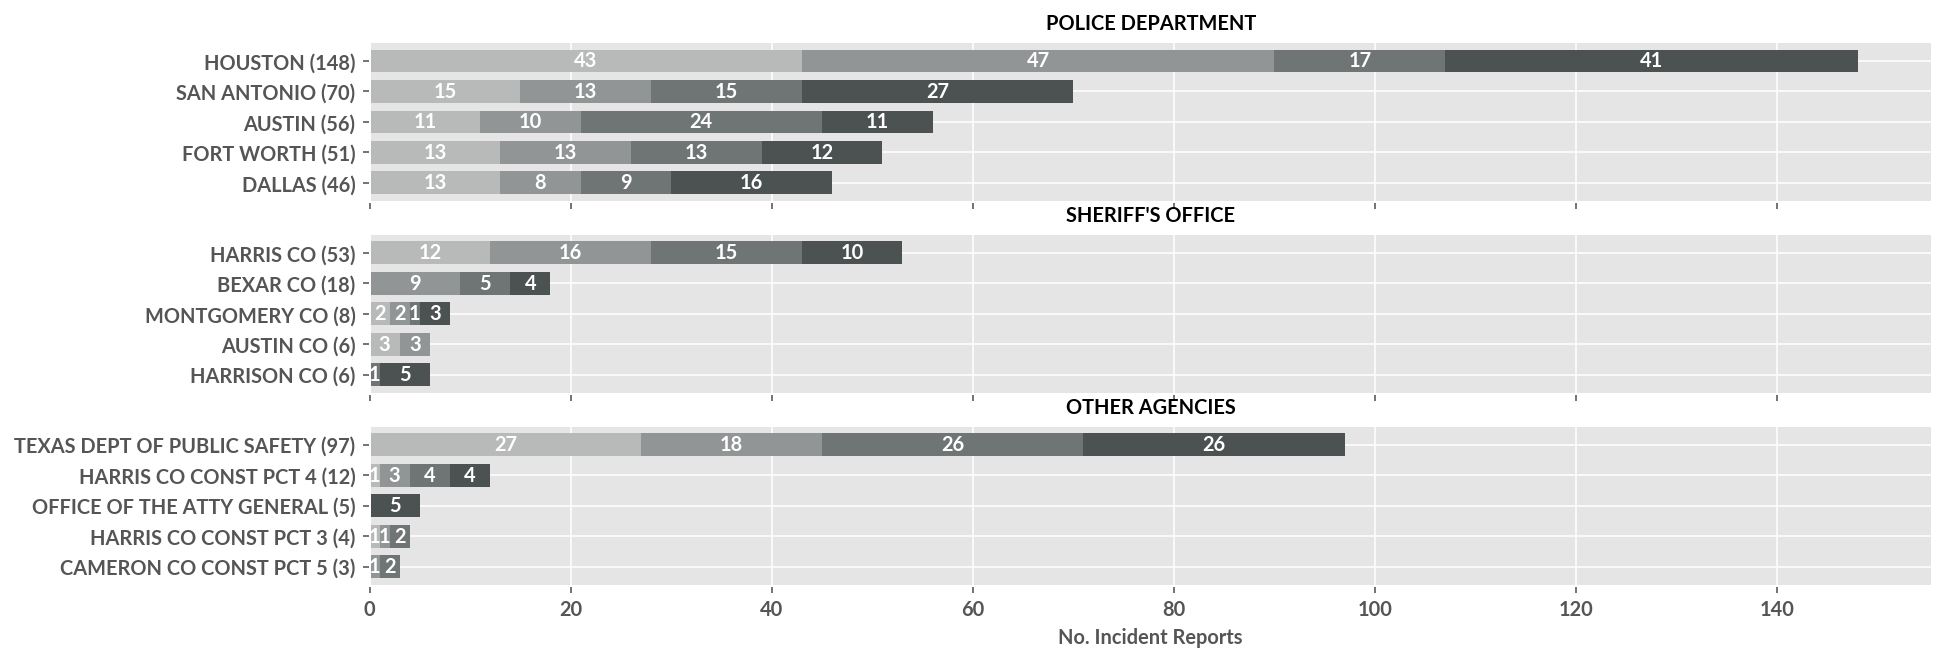

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(14, 5), sharex=True)
for i, (df, title) in enumerate(zip(list(df_agency_count_plot.values()), 
                                    ['Police Department', "Sheriff's Office", 'Other Agencies'])):
    ax = axes[i]
    df_ = df.T[::-1].loc[:, years]
    inds_order = df_.sum(axis=1).sort_values().index
    df_ = df_.loc[inds_order, :]
    df_.plot(kind='barh', ax=ax, title=title.upper(), color=cols_year,
             width=0.75, legend=False, stacked=True)
    if i == 2:
        ax.set_xlabel('No. Incident Reports')
    plot.annotate(ax, 'h', threshold=0, fontsize=10)
    
    ax.set_yticklabels([s + ' ({})'.format(int(n)) for s, n in zip(df_.index, df_.sum(axis=1))], rotation=0, fontsize=10)

## 2. Officer dataset

In [51]:
agency_names_os = ['agency_name_1', 'agency_name_2']

In [52]:
df_agency_count, df_agency_count_plot = preprocess.count_agencies_by_year_type(df_os, agency_names_os, 5)

In [53]:
df_agency_count

,n_police,police_top,n_sheriff,sheriff_top,n_other,other_top
2016,12,DALLAS POLICE DEPT 8 HOUSTON POLICE DE...,3,HARRIS CO SHERIFFS OFFICE 1 dtype: int64,5,HARRIS CO CONST PCT 5 2 MONTGOMERY CO...
2017,10,LAREDO POLICE DEPT 5 SAN ANTONIO POLIC...,3,HAYS CO SHERIFFS OFFICE 1 dtype: int64,3,TEXAS DEPT OF PUBLIC SAFETY 2 HARRIS CO CON...
2018,12,DALLAS POLICE DEPT 2 SAN ANTONIO POLIC...,4,BEXAR CO SHERIFFS OFFICE 2 HARRIS CO SHERI...,3,OFFICE OF THE ATTY GENERAL 2 TEXAS DEPT OF...
2019,14,HOUSTON POLICE DEPT 7 LAREDO POLICE DEP...,7,HARRIS CO SHERIFFS OFFICE 3 ECTOR CO SHERIF...,2,TEXAS DEPT OF PUBLIC SAFETY 3 HARRIS CO CON...


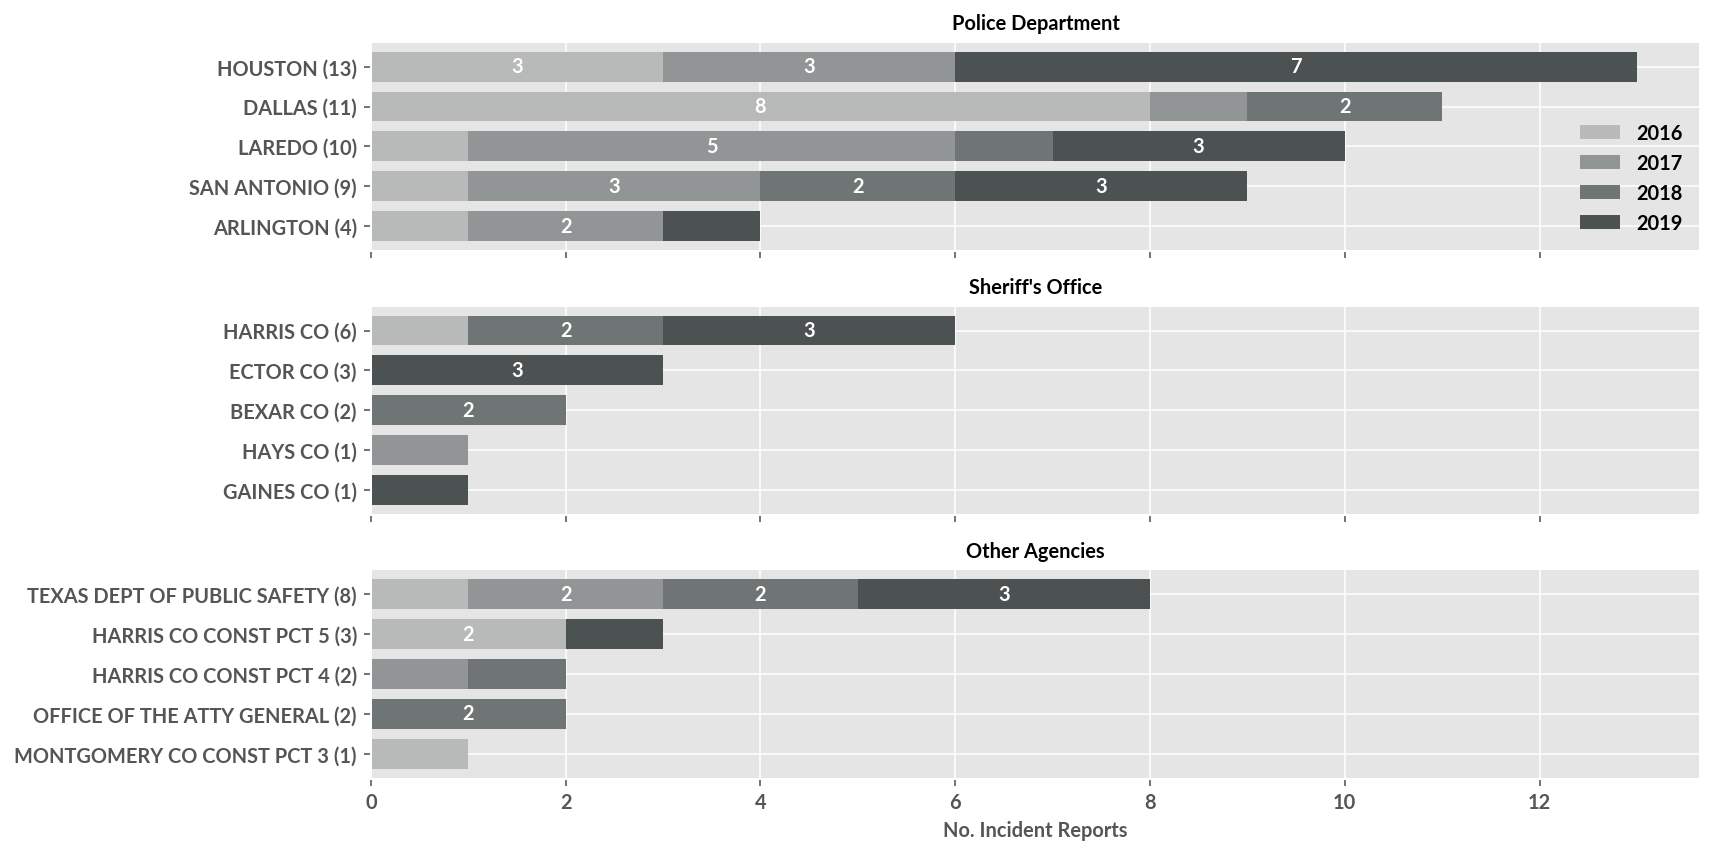

In [54]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
for i, (df, title) in enumerate(zip(list(df_agency_count_plot.values()), 
                                    ['Police Department', "Sheriff's Office", 'Other Agencies'])):
    ax = axes[i]
    df_ = df.T[::-1].loc[:, years]
    inds_order = df_.sum(axis=1).sort_values().index
    df_ = df_.loc[inds_order, :]
    df_.plot(kind='barh', ax=ax, title=title, color=cols_year,
             width=0.75, legend=False, stacked=True)
    if i == 0:
        ax.legend(years)
    if i == 2:
        ax.set_xlabel('No. Incident Reports')
    plot.annotate(ax, 'h', threshold=1, fontsize=10)
    
    ax.set_yticklabels([s + ' ({})'.format(int(n)) for s, n in zip(df_.index, df_.sum(axis=1))], rotation=0, fontsize=10)

fig.tight_layout();

## 3. Together

In [55]:
df_merged = pd.concat([df_cd[agency_names_cd + ['year']], df_os[agency_names_os + ['year']]], axis=0)
df_merged.head()

,agency_name_1,agency_name_2,agency_name_3,agency_name_4,agency_name_5,agency_name_6,agency_name_7,agency_name_8,agency_name_9,agency_name_10,agency_name_11,year
66,SWEETWATER POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
67,FORNEY POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
68,ABILENE POLICE DEPT,ABILENE POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
69,SAN ANTONIO POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
70,FORNEY POLICE DEPT,FORNEY POLICE DEPT,MESQUITE POLICE DEPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016


In [56]:
df_agency_count, df_agency_count_plot = preprocess.count_agencies_by_year_type(df_merged, 
                                                                               agency_names_cd, 5)

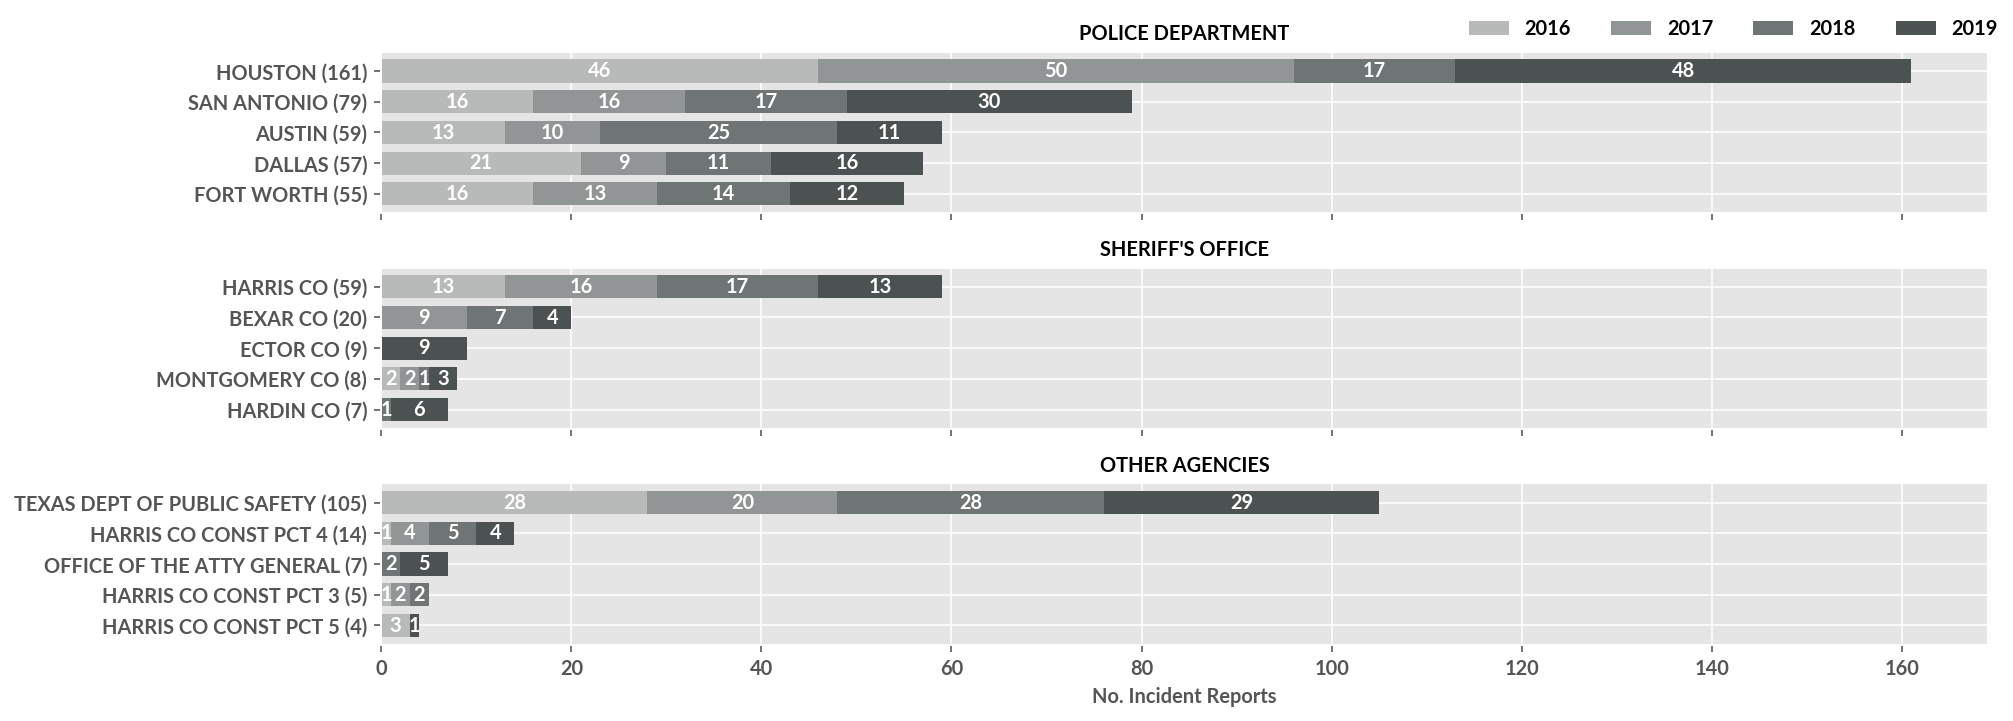

In [57]:
fig, axes = plt.subplots(3, 1, figsize=(14, 5), sharex=True)
for i, (df, title) in enumerate(zip(list(df_agency_count_plot.values()),
                                    ['Police Department', "Sheriff's Office", 'Other Agencies'])):
    ax = axes[i]
    df_ = df.T[::-1].loc[:, years]
    inds_order = df_.sum(axis=1).sort_values().index
    df_ = df_.loc[inds_order, :]
    df_.plot(kind='barh', ax=ax, title=title.upper(), color=cols_year,
             width=0.75, legend=False, stacked=True)
    if i == 2:
        ax.set_xlabel('No. Incident Reports')
    plot.annotate(ax, 'h', fontsize=10)
    
    ax.set_yticklabels([s + ' ({})'.format(int(n)) for s, n in zip(df_.index, df_.sum(axis=1))], rotation=0, fontsize=10)

fig.legend(years, ncol=len(years), bbox_to_anchor=(1, 1), fontsize=10)
fig.tight_layout()    
fig.savefig('../Figures/Figure_14.eps', bbox_inches='tight')        